In [12]:
import numpy as np
import depth_calculation as dc
import matplotlib.pylab as plt
%matplotlib inline
import os.path
import sys

custom_file = open ('custom_file.txt',"rb")
path=[ line for line in custom_file ][1].decode("utf-8")
custom_file.close()
path_of_qudi = str(path)
sys.path.append(path_of_qudi)
from tools.fit_logic_standalone import FitLogic
fitting = FitLogic(path_of_qudi)

In [13]:
## give values here
# gyromagnetic ratio electron
gamma_e = 2*np.pi*2.8025*1e4  # in MHz/T  (divided by 2pi)
# gyromagnetic ratio proton
gamma_p = 42.58       # in MHz/T  (divided by 2pi)
gamma_p *= 1e6        # to get Hz/T
# spin density
rho = 50              # in 1/nm^3
# vacuum permeability
mu_0 = 4*np.pi*1e-7
# Planck constant
h = 6.62607e-34

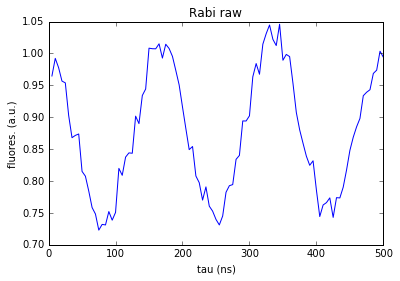

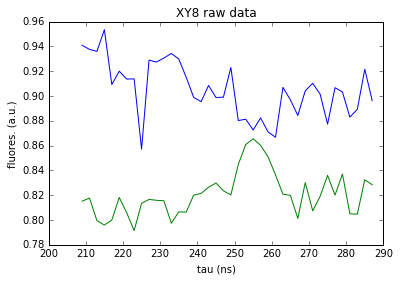

In [45]:
## Import data
#rabi_file = 'D:\\Git\\DepthCalculations\\example_rabi.asc'
#xy8_file = 'D:\\Git\\DepthCalculations\\example_xy8-4.asc'
#N = 4
rabi_file = 'D:\\Hyperdiamond\\Experimental_results\\1611\\pyruvate_measurements\\oil\\20161104-1952-00_NV20_Rabi4_pulsed_measurement.dat'
xy8_file = 'D:\\Hyperdiamond\\Experimental_results\\1611\\pyruvate_measurements\\oil\\NV21_XY8-16_merged.dat'
N = 16
#rabi_file = 'D:\\Hyperdiamond\\Experimental_results\\1611\\pyruvate_measurements\\pyruvate\\20161115-1717-15_Rabi_NV21_0p7V_pulsed_measurement.dat'
#xy8_file = 'D:\\Hyperdiamond\\Experimental_results\\1611\\pyruvate_measurements\\pyruvate\\20161115-1851-39_XY8-8_NV21_471G_pulsed_measurement.dat'
#N = 8

rabi_x, rabi_y = dc.get_data(rabi_file, data_columns=2)
xy8_x, xy8_y1, xy8_y2 = dc.get_data(xy8_file, data_columns=3)

if xy8_y1.mean() < xy8_y2.mean():
    xy8_y1, xy8_y2 = xy8_y2, xy8_y1

plt.plot(rabi_x, rabi_y)
plt.title('Rabi raw')
plt.xlabel('tau (ns)')
plt.ylabel('fluores. (a.u.)')
plt.show()

plt.plot(xy8_x, xy8_y1)
plt.plot(xy8_x, xy8_y2)
plt.title('XY8 raw data')
plt.xlabel('tau (ns)')
plt.ylabel('fluores. (a.u.)')
plt.show()

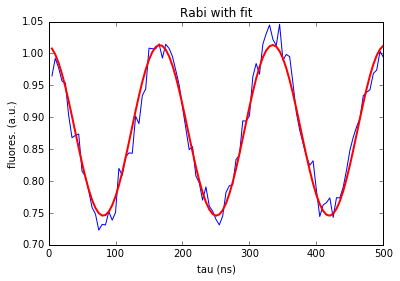

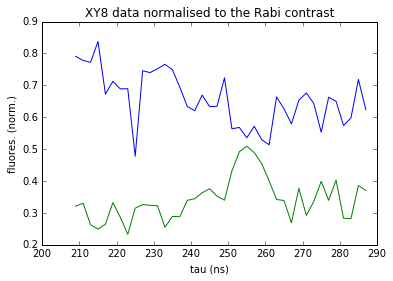

In [46]:
## perform Rabi fit and do normalization of the xy8 data
# Rabi fit
rabi_fit_result = fitting.make_sine_fit(axis=rabi_x,data=rabi_y)
rabi_offset = rabi_fit_result.params['offset'].value
rabi_amplitude = rabi_fit_result.params['amplitude'].value
plt.plot(rabi_x, rabi_y)
plt.plot(rabi_x,rabi_fit_result.best_fit,linewidth=2.,color="r")
plt.title('Rabi with fit')
plt.xlabel('tau (ns)')
plt.ylabel('fluores. (a.u.)')
plt.show()
# do XY8 normalisation
level = ((np.array(xy8_y1)+np.array(xy8_y2))/2).mean()
xy8_y1_norm = dc.do_normalisation(xy8_y1, rabi_amplitude, level)
xy8_y2_norm = dc.do_normalisation(xy8_y2, rabi_amplitude, level)
plt.plot(xy8_x, xy8_y1_norm)
plt.plot(xy8_x, xy8_y2_norm)
plt.title('XY8 data normalised to the Rabi contrast')
plt.xlabel('tau (ns)')
plt.ylabel('fluores. (norm.)')
plt.show()

In [47]:
# I should implement this in a general form!
xy8_y2_norm[23] = (xy8_y2_norm[22]+xy8_y2_norm[22])/2
xy8_y1_norm[8] = (xy8_y1_norm[7]+xy8_y1_norm[9])/2

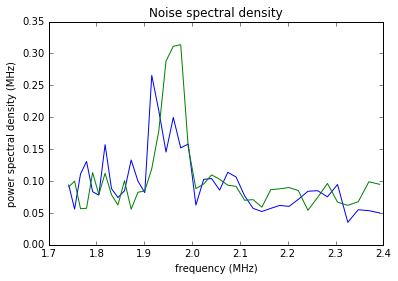

In [48]:
## calculate noise density spectrum
nu = dc.nu_from_tau(xy8_x)*1000  # frequency is in MHz then
tau_x = xy8_x/1e9 # to have the tau values in seconds
spectrum1 = dc.S_from_data(tau_x, xy8_y1_norm, 1, 8*N)/1e6     # the plot is in MHz then, since I use gamma_e=1
spectrum2 = dc.S_from_data(tau_x, 1-xy8_y2_norm, 1, 8*N)/1e6   # the plot is in MHz then, since I use gamma_e=1
plt.plot(nu, spectrum1)
plt.plot(nu, spectrum2)
plt.title('Noise spectral density')
plt.xlabel('frequency (MHz)')
plt.ylabel('power spectral density (MHz)')
plt.show()

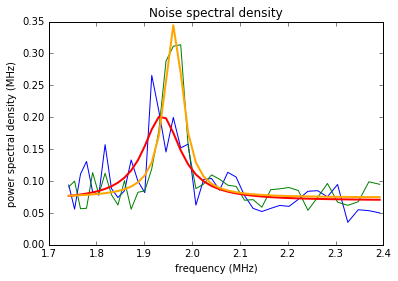

In [49]:
## perform Lorentzian fits
spectrum1_fit_result = fitting.make_lorentzianpeak_fit(axis=nu,data=spectrum1)
spectrum2_fit_result = fitting.make_lorentzianpeak_fit(axis=nu,data=spectrum2)
plt.plot(nu, spectrum1)
plt.plot(nu, spectrum2)
plt.plot(nu, spectrum1_fit_result.best_fit,linewidth=2.,color="red")
plt.plot(nu, spectrum2_fit_result.best_fit,linewidth=2.,color="orange")
plt.title('Noise spectral density')
plt.xlabel('frequency (MHz)')
plt.ylabel('power spectral density (MHz)')
plt.show()

In [50]:
## get the integral of the magnetic noise
spectrum1_area = np.pi * spectrum1_fit_result.params['height'].value * spectrum1_fit_result.params['fwhm'].value/2
spectrum2_area = np.pi * spectrum2_fit_result.params['height'].value * spectrum2_fit_result.params['fwhm'].value/2
# note that this areas are in MHz^2
B1 = (2*spectrum1_area/gamma_e**2)**0.5   # B1 is in Tesla now
B2 = (2*spectrum2_area/gamma_e**2)**0.5   # B2 is in Tesla now
print('B1 =', B1)
print('B2 =', B2)

B1 = 1.134083475992907e-06
B2 = 1.1312061365773951e-06


In [43]:
## calculate the depth of the NV for given spin density:
rho1 = rho
rho2 = rho
depth1 = dc.calculate_depth_simple(mu_0, h, B1, gamma_p, rho1)
depth2 = dc.calculate_depth_simple(mu_0, h, B2, gamma_p, rho2)
mean_depth = (depth1+depth2)/2
print('depth1 =', depth1, 'nm')
print('depth2 =', depth2, 'nm')
print('mean depth =', mean_depth, 'nm')

depth1 = 3.8007085451158784 nm
depth2 = 4.130730721731116 nm
mean depth = 3.9657196334234976 nm


In [44]:
## calcuate the spin density for given depth:
d1 = depth1
d2 = depth2
rho1 = dc.calculate_density_simple(mu_0, h, B1, gamma_p, d1)
rho2 = dc.calculate_density_simple(mu_0, h, B2, gamma_p, d2)
print('rho1 =', rho1, 'nm^-3')
print('rho2 =', rho2, 'nm^-3')

rho1 = 46.12978969533007 nm^-3
rho2 = 35.93308647219077 nm^-3
